In [3]:
import csv
import math as m
from random import uniform as unif
import networkx as nx
import pandas as pd
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, HTML
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [4]:
expid = "./exp2_run0"

In [5]:
if not os.path.exists(expid):
    os.makedirs(expid)

# Problem instance

## Geographic data

In [6]:
from pkg.read_problem import read_problem, extract_problem

In [7]:
xy_customers, xy_icps, xy_crcs, xy_pc, q = read_problem('./datasets/original')

In [8]:
xy_icps = xy_icps + [[unif(20,100),unif(20,70)] for i in range(5)]
xy_crcs = xy_crcs + [[unif(20,100),unif(20,70)] for i in range(1)]

In [9]:
I,J,C,B,K,V,W,DjUc,Dcj,Dc,FCV,FCT,FCR,U = extract_problem(xy_customers, xy_icps, xy_crcs, xy_pc, q)

## Capacity constraints

In [10]:
Q_icp = [200 for j in range(J)]
Q_crc = [800 for c in range(C)]
V = [Q_icp,Q_crc]

## Adapting costs

In [11]:
# two-level cost
FCRD = []
for c in range(C):
    FCRD.append(FCR[c] + Dc[c])

f = FCT+FCRD
c = [[[W[i][j1] + Dcj[j1][j2] for j2 in range(C)] for j1 in range(J)] for i in range(I)]

# Plot Problem

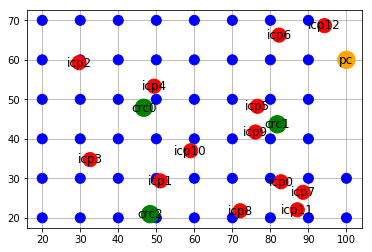

In [12]:
from pkg.lrp_nodes_graph import lrp_nodes_graph, lrp_draw_and_save
G, pos, labels, colors, size = lrp_nodes_graph(xy_customers, xy_icps, xy_crcs, xy_pc)

lrp_draw_and_save(G, pos, labels, colors, size, expid+"/problem.png")

# Define Functions

In [27]:
%%file "./pkg/cflp_first_tsp_second.py"

def cflp_first_tsp_second(G,pos, labels, colors, size,
                I,J,C,
                W1,W2,W3,F1,F2,
                U,Q_icp,Q_crc,
                plots=True, expid=""):
    
    from pkg.cflp_cplex import cflp_cplex
    from pkg.tsp_cplex import tsp_cplex
    from pkg.read_problem import read_problem, extract_problem
    from pkg.lrp_nodes_graph import lrp_nodes_graph, lrp_draw_and_save
    import numpy as np
    import pandas as pd
    from IPython.display import display, HTML

    #######################################################################
    # Solve first problem
    prob1, Y1, N_icp = cflp_cplex(I,J,
                W1,F1,U,Q_icp,
                relaxation=False)
    
    #######################################################################
    # Prepare 2nd problem
    H1 = [j for j,vj in enumerate(N_icp) if vj > 0.5]
    
    c2=[];    u2=[];
    for j in H1:
        c2.append(W2[j])
        sqi = 0
        for i in range(I):
            sqi += U[i]*Y1[i][j]
        u2.append(sqi)
    #######################################################################        
    # Solve Second problem
    prob2, Y2, N_crc = cflp_cplex(len(u2),C,
            c2,F2,u2,Q_crc,
            relaxation=False)    
    #######################################################################
    # Preparing TSP
    H2 = [j for j,vj in enumerate(N_crc) if vj > 0.5]
    tY2 = np.transpose(Y2)
    W3 = np.asarray(W3)
    
    #/!\ Use H1 as a labeling array

    S_tsp = [] #set of ICP in each TSP
    for c,vc in enumerate(H2):
        S_tsp.append([H1[j] for j,vj in enumerate(tY2[c]) if vj > 0.5]+[J+vc])
    
    w_tsp = []
    for submat in S_tsp:
        w_tsp.append(W3[submat,:][:,submat])
    #######################################################################
    # Solving TSP
    routes = []
    for c,vc in enumerate(w_tsp):
        prob, X = tsp_cplex(len(vc),vc, relaxation=False)
        # Extract routes
        path = []
        for j,xj in enumerate(X):
            for i,xij in enumerate(xj):
                if xij == 1:
                    path.append((S_tsp[c][i],S_tsp[c][j]))
        routes.append(path)
    #######################################################################
    # Draw solution
    if(plots):
        ###############################
        # DataFrames
        display(pd.DataFrame(N_crc).transpose())
        display(pd.DataFrame(N_icp).transpose())
        for c,vc in enumerate(w_tsp):
            display(pd.DataFrame(path).transpose())   
        ###############################
        # Network
        G2 = G.copy()
        colors = colors[:];size = size[:];
        # ICP-Cus
        for j,vj in enumerate(Y1):
            for i,vi in enumerate(vj):
                if vi == 1:
                    G2.add_edge(I+i,j)
        # ICP
        for j,vj in enumerate(N_icp):
            if vj < 0.5:
                colors[I+j] = "grey"
                labels[I+j] = ""
                size[I+j] = 50
                
        # ICP-CRC
        for j,vj in enumerate(Y2):
            for i,vi in enumerate(vj):
                if vi == 1:
                    G2.add_edge(I+J+i,I+H1[j])
        # CRC
        for j,vj in enumerate(N_crc):
            if vj < 0.5:
                colors[I+J+j] = "grey"
                labels[I+J+j] = ""
                size[I+J+j] = 50
                
        # Routes
        for r,vr in enumerate(routes):
            for c, vc in enumerate(vr):
                G2.add_edge(I+vc[0],I+vc[1])

        lrp_draw_and_save(G2, pos, labels, colors, size, expid+"/cflp_cplex.png")
    
    return Y1, N_icp, N_crc, routes

Overwriting ./pkg/cflp_first_tsp_second.py


In [20]:
from pkg.cflp_first_tsp_second import cflp_first_tsp_second

,0,1,2
0,1.0,1.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


,0,1,2,3,4
0,6,14,8,5,7
1,5,6,7,8,14


,0,1,2,3,4
0,6,14,8,5,7
1,5,6,7,8,14


Wall time: 364 ms


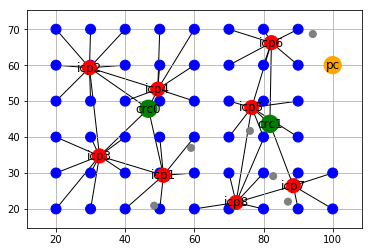

In [28]:
%%time
Y, N_icp, N_crc, routes = cflp_first_tsp_second(G,pos, labels, colors, size,
                I,J,C,
                W,Dcj,DjUc,FCT,FCRD,
                U,Q_icp,Q_crc,
                expid=expid)

In [192]:
from pkg.objective_III import objective_III

In [193]:
objective_III(Y,routes,N_icp, N_crc,
                I,J,C,B,
                W,DjUc,Dc,
                FCV,FCT,FCR)

(2570.1543527942758,
 514.90978984208959,
 176.175733426272,
 800.0,
 1079.0688295259142)

In [50]:
def swap_list(Y,W,DjUc,N_icp):
    cluster_len = np.max(np.multiply(Y,W),axis=0)
    swaps = []
    for j,l in enumerate(cluster_len):
        for j_bis,n in enumerate(DjUc[j]):
            if n<l and j != j_bis and j_bis < J and N_icp[j_bis] == 0:
                swaps.append((j,j_bis))
    return swaps

In [51]:
swap_list(Y,W,DjUc,N_icp)

[(1, 10), (4, 10), (5, 9), (6, 12), (7, 0), (7, 11)]

In [64]:
routes

[[(13, 1), (3, 2), (1, 3), (2, 4), (4, 13)],
 [(6, 5), (14, 6), (8, 7), (5, 8), (7, 14)]]

In [72]:
def swap_list_byRoute(Y,W,DjUc,N_icp):
    cluster_len = np.max(np.multiply(Y,W),axis=0)
    swaps = []
    for iroute,route in enumerate(routes):
        for iarc,arc in enumerate(route): #chose on element
            if arc[0] < len(cluster_len): # do not select CRC
                for j_bis,n in enumerate(DjUc[arc[0]]): # look at other
                    if j_bis < len(cluster_len):
                        if n<cluster_len[arc[0]] and cluster_len[j_bis] == 0 and arc[0] != j_bis:
                            coarc = [co for co in route if co[1] == arc[0]]
                            swaps.append((iroute,arc,coarc[0],j_bis))
                            
    return swaps

In [73]:
swap_list_byRoute(Y,W,DjUc,N_icp)

[(0, (1, 3), (13, 1), 10),
 (0, (4, 13), (2, 4), 10),
 (1, (6, 5), (14, 6), 12),
 (1, (5, 8), (6, 5), 9),
 (1, (7, 14), (8, 7), 0),
 (1, (7, 14), (8, 7), 11)]

In [238]:
tY = np.transpose(np.copy(Y))
tY[1], tY[12]

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))

In [239]:
swap = swaps[0]
# Update 
temp = tY[swap[0]].copy()
tY[swap[0]] = tY[swap[1]]
tY[swap[1]] = temp[:]

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))

In [232]:
matrix = [[1,1,1],[2,3,4],[4,5,6],[7,1,2],[1,2,3]]
matrix[1], matrix[2] = matrix[2], matrix[1]
matrix

[[1, 1, 1], [4, 5, 6], [2, 3, 4], [7, 1, 2], [1, 2, 3]]

# Run experiment

## Results

In [151]:
objects = ('UFLP', 'CFLP', 'TUFLP', 'TCFLP')
y_pos = np.arange(len(objects))
performance = [result1.best,result2.best,result3.best,result4.best]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time s')
plt.title('Best processing time for each subproblem')
 
plt.show()

NameError: name 'result1' is not defined